In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


mpl.rcParams['figure.dpi']= 150

In [2]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT.values
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


In [3]:
# You only need to run this once
gbm = xgb.XGBRegressor(learning_rate=0.01,  
                       objective='reg:squarederror', 
                       n_estimators=2000, 
                       reg_alpha=1,
                       reg_lambda=10,
                       max_depth=10, 
                       gamma=0.1)
gbm.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=1, reg_lambda=10, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [4]:
def oneRun(z_guess):
    # Read all data and merge
    thick_con_interpolated = []
    for i in range(0,49):
        temp_df = pd.read_csv('Mult'+str(i))
        # print(i, temp_df.iloc[:,2].values)
        thick_con_interpolated.append(temp_df.iloc[:,2].values)
    # Transpose to match the format
    thick_con_interpolated = np.transpose(np.array(thick_con_interpolated))
    df_interpolated = pd.DataFrame({'lat':temp_df.iloc[:,1].values,'lon':temp_df.iloc[:,0].values,
                                'z':np.full((len(temp_df.iloc[:,0].values),),z_guess),
                                't_surf':pd.read_csv('T_surf_knn').iloc[:,2].values}) # z is all z guess
    X_interpolated = np.concatenate((df_interpolated.values,thick_con_interpolated),axis=1)
    X_interpolated.shape
    xgb_pred = gbm.predict(X_interpolated)
    return xgb_pred

In [5]:
xgb_preds = []

for i in np.array(list(range(1,31)))*100:
    curr_pred = oneRun(i)
    xgb_preds.append(curr_pred)

In [47]:
gradients = []
rsq = []
for i in range(0, 28125):
    curr_preds = []
    for j in range(0, 30):
        curr_preds.append(xgb_preds[j][i])
    
    reg = LinearRegression().fit((np.array(list(range(1,31)))*100).reshape(-1,1),
                                 np.array(curr_preds))
    gradients.append(reg.coef_[0])
    rsq.append(reg.score((np.array(list(range(1,31)))*100).reshape(-1,1),
                                 np.array(curr_preds)))

In [42]:
df_t = pd.read_csv('Mult0')

Text(0.5, 1.0, 'Gradient Map with XGBoost')

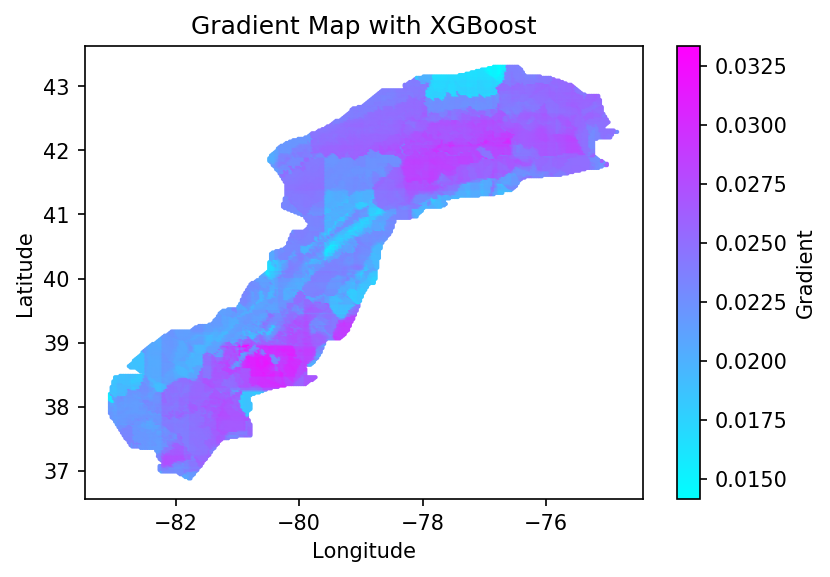

In [44]:
plt.scatter(df_t.long, df_t.lat, c=np.array(gradients), cmap='cool',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar().set_label('Gradient')
plt.title('Gradient Map with XGBoost')

In [48]:
df_tt = pd.DataFrame({'rsq':rsq})
df_tt

,rsq
0,0.961510
1,0.964433
2,0.959250
3,0.960141
4,0.964604
...,...
28120,0.989202
28121,0.990721
28122,0.991221
28123,0.979787


In [49]:
df_tt.describe()

,rsq
count,28125.000000
mean,0.972999
std,0.019858
min,0.858948
25%,0.966775
50%,0.977782
75%,0.986697
max,0.997869
